In [1]:
#Importing necessary libraries like pandas and numpy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#Loading the excel data into the dataframe. Date column is marked as index and it is also parsed that way Python recognizes that column as date variable
#Printing the data to look at the shape
df = pd.read_excel(r'H:\Demand Forecasting\Data\Spend\Data v4\Data_BM.xlsx',index_col='date',parse_dates=True)
print('Shape of data',df.shape)
df.tail()

Shape of data (165, 7)


,business_unit,product,country,month,year,qty,amt
date,,,,,,,
2022-05-29,Automotive,Base Metals,United States,May,2022,462,5028908
2022-06-05,Automotive,Base Metals,United States,June,2022,477,6018685
2022-06-12,Automotive,Base Metals,United States,June,2022,480,5822638
2022-06-19,Automotive,Base Metals,United States,June,2022,477,5499921
2022-06-26,Automotive,Base Metals,United States,June,2022,474,5629392


In [3]:
#Removing all unnecessary columns and keeping only date and amt columns for further analysis
df.drop(["business_unit","country","qty","month","year","product"], axis=1, inplace=True)
df.head()

,amt
date,
2019-05-05,5003053
2019-05-12,4665940
2019-05-19,5545590
2019-05-26,5692459
2019-06-02,5125903


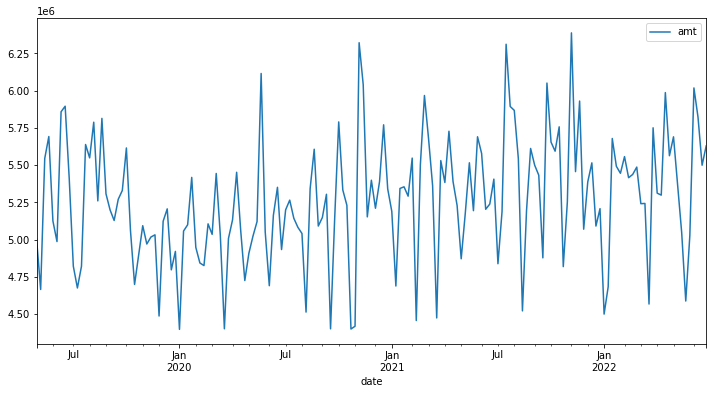

In [4]:
#Plotting the data into a line chart to help us better visualize it
df.plot(figsize=(12,6))

In [5]:
#Import the seasonal decompose library to visualize the data better
from statsmodels.tsa.seasonal import seasonal_decompose

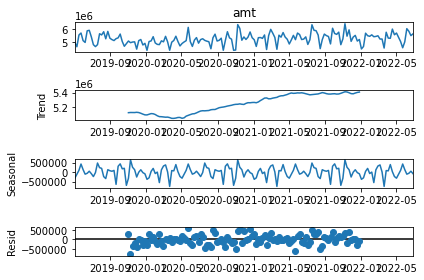

In [6]:
#The seasonal decompose of the data shows how the data looks like originally, how it looks with just the trend, with just seasonality and just the noise
results = seasonal_decompose(df['amt'])
results.plot();

In [7]:
len(df)

165

In [8]:
#Splitting the training and test dataset
print(df.shape)
train=df.iloc[:-4]
test=df.iloc[-4:]
print(train.shape,test.shape)

(165, 1)
(161, 1) (4, 1)


In [9]:
#Importing the MinMaxScaler library
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [10]:
df.head(),df.tail()

(                amt
 date               
 2019-05-05  5003053
 2019-05-12  4665940
 2019-05-19  5545590
 2019-05-26  5692459
 2019-06-02  5125903,
                 amt
 date               
 2022-05-29  5028908
 2022-06-05  6018685
 2022-06-12  5822638
 2022-06-19  5499921
 2022-06-26  5629392)

In [11]:
#MinMaxScaler compresses the data between 0 and 1
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [12]:
#Checking the data after running the MixMaxScaler
scaled_train[:10]

array([[0.30395858],
       [0.13457702],
       [0.5765549 ],
       [0.65034885],
       [0.36568425],
       [0.29609227],
       [0.73388827],
       [0.75262102],
       [0.5081914 ],
       [0.21298646]])

In [13]:
#Importing TimeSeries Generator from Keras library
from keras.preprocessing.sequence import TimeseriesGenerator

In [14]:
#setting the input as 3 and features as 1 that way the model will learn first 3 values and predict the 4th value to test it
n_input = 3
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [15]:
X,y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.30395858 0.13457702 0.5765549 ]
Predict this y: 
 [[0.65034885]]


In [16]:
X.shape

(1, 3, 1)

In [17]:
#Changed the input to 12
n_input = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [18]:
#Importing necesssary libraries like Sequential, Dense and LSTM
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [19]:
#LSTM model is run with 100 neurons. Activation selected as 'relu'. Optimizer as 'adam' and loss as 'mse'
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [21]:
#The model is run for 50 epochs. The epoch with the lowest loss is selected as the best epoch which the LSTM will automatically take it
model.fit(generator,epochs=50)

Epoch 1/50
149/149 [==============================] - 7s 15ms/step - loss: 0.0540
Epoch 2/50
149/149 [==============================] - 2s 15ms/step - loss: 0.0435
Epoch 3/50
149/149 [==============================] - 2s 14ms/step - loss: 0.0428
Epoch 4/50
149/149 [==============================] - 2s 14ms/step - loss: 0.0426: 0s - lo
Epoch 5/50
149/149 [==============================] - 2s 15ms/step - loss: 0.0430
Epoch 6/50
149/149 [==============================] - 2s 15ms/step - loss: 0.0457
Epoch 7/50
149/149 [==============================] - 2s 16ms/step - loss: 0.0414
Epoch 8/50
149/149 [==============================] - 2s 14ms/step - loss: 0.0428
Epoch 9/50
149/149 [==============================] - 2s 16ms/step - loss: 0.0415
Epoch 10/50
149/149 [==============================] - 2s 16ms/step - loss: 0.0426: 1s - loss: 0.05 - ETA: 1s  - ETA: 0s - loss: 0.04 - ETA: 0s - loss: 0.045 - ETA: 0s -
Epoch 11/50
149/149 [==============================] - 2s 15ms/step - loss: 0.0410


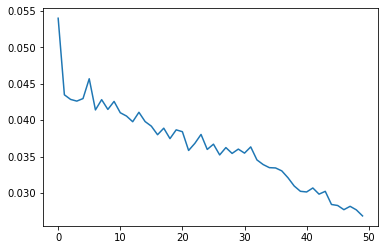

In [22]:
#The loss for each epoch is visualized in a trend line
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [23]:
last_train_batch = scaled_train[-12:]

In [24]:
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

In [25]:
model.predict(last_train_batch)

array([[0.94877136]], dtype=float32)

In [26]:
scaled_test[0]

array([0.81426026])

In [27]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [28]:
#The predicted values after the model is run
test_predictions

[array([0.94877136], dtype=float32),
 array([0.93886364], dtype=float32),
 array([0.60125303], dtype=float32),
 array([0.6259949], dtype=float32)]

In [29]:
test.head()

,amt
date,
2022-06-05,6018685
2022-06-12,5822638
2022-06-19,5499921
2022-06-26,5629392


In [30]:
#Moving back the values to their original self 
true_predictions = scaler.inverse_transform(test_predictions)

In [31]:
test['Predictions'] = true_predictions

<ipython-input-31-920b79c3c314>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


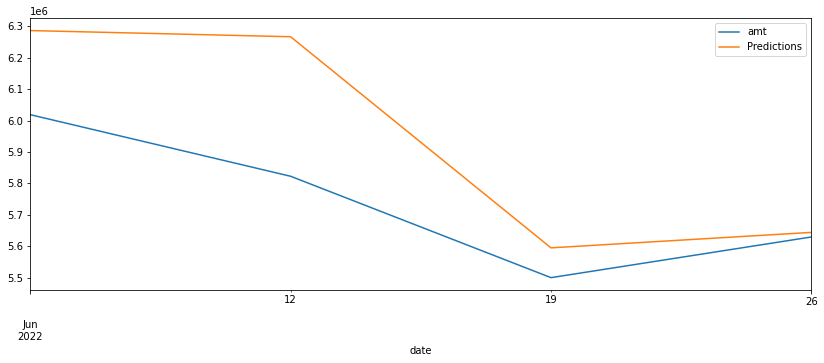

In [32]:
#Plotting the test and predicted data along the trend chart
test.plot(figsize=(14,5))

In [33]:
#Printing the rmse of test data and predicted data
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(test['amt'],test['Predictions']))
print(rmse)

263650.22664913815


In [34]:
avg=test['amt'].mean()
print(avg)

5742659.0


In [35]:
#The accuracy of the model
accuracy=(rmse/avg)*100
accuracy=100-accuracy
print(accuracy)

95.40891725158784


In [36]:
#the future 4 weeks prediction
true_predictions

array([[6286396.78450751],
       [6266677.86059356],
       [5594745.65832424],
       [5643988.39894342]])